<a href="https://colab.research.google.com/github/Muhamad-Nady/Machine-Learning__Data-Analysis/blob/main/Jumia_taxonomy/Jumia_taxonomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving الصفحة الرئيسية.zip to الصفحة الرئيسية.zip
User uploaded file "الصفحة الرئيسية.zip" with length 23470694 bytes


In [ ]:
!unzip /content/'الصفحة الرئيسية.zip' -d /content

Archive:  /content/الصفحة الرئيسية.zip
   creating: /content/الصفحة الرئيسية/
   creating: /content/الصفحة الرئيسية/الكمبيوتر/
   creating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/
   creating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/الكمبيوتر والتابلت/
   creating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/الكمبيوتر والتابلت/لاب توب/
   creating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/الكمبيوتر والتابلت/لاب توب/لاب توب 2 في 1/
  inflating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/الكمبيوتر والتابلت/لاب توب/لاب توب 2 في 1/sample0.jpg  
  inflating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/الكمبيوتر والتابلت/لاب توب/لاب توب 2 في 1/sample1.jpg  
  inflating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/الكمبيوتر والتابلت/لاب توب/لاب توب 2 في 1/sample2.jpg  
  inflating: /content/الصفحة الرئيسية/الكمبيوتر/الكمبيوتر وملحقاته/الكمبيوتر والتابلت/لاب توب/لاب توب 2 في 1/sample3.jpg  
  inflating: /content

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = '/content/الصفحة الرئيسية'
train_dir = base_dir
#validation_dir = os.path.join(base_dir, 'validation')
#test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
                  directory,
                  target_size=(150, 150),
                  batch_size=batch_size,
                  class_mode='categorical')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      # Note that since generators yield data indefinitely in a loop,
      # we must `break` after every image has been seen once.
      break
  return features, labels

In [ ]:
features, labels = extract_features(train_dir, 2225)

Found 2225 images belonging to 11 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
image_size = (150, 150)
batch_size = 20

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    #label='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    #label='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2225 files belonging to 11 classes.
Using 1780 files for training.
Found 2225 files belonging to 11 classes.
Using 445 files for validation.


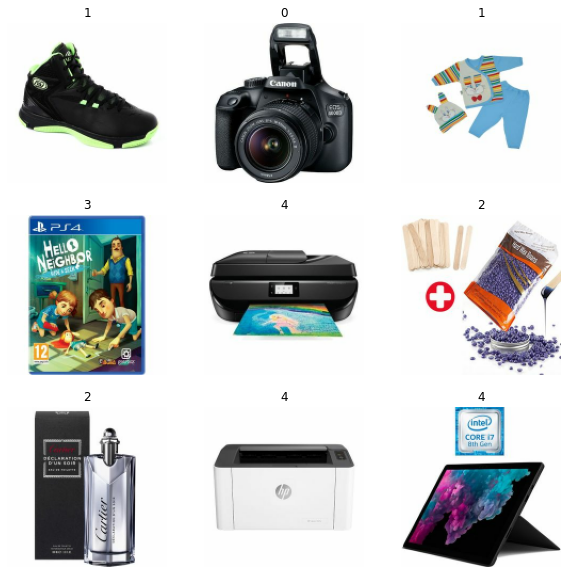

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ])

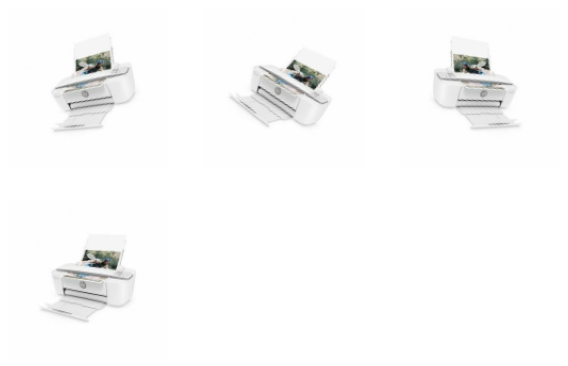

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

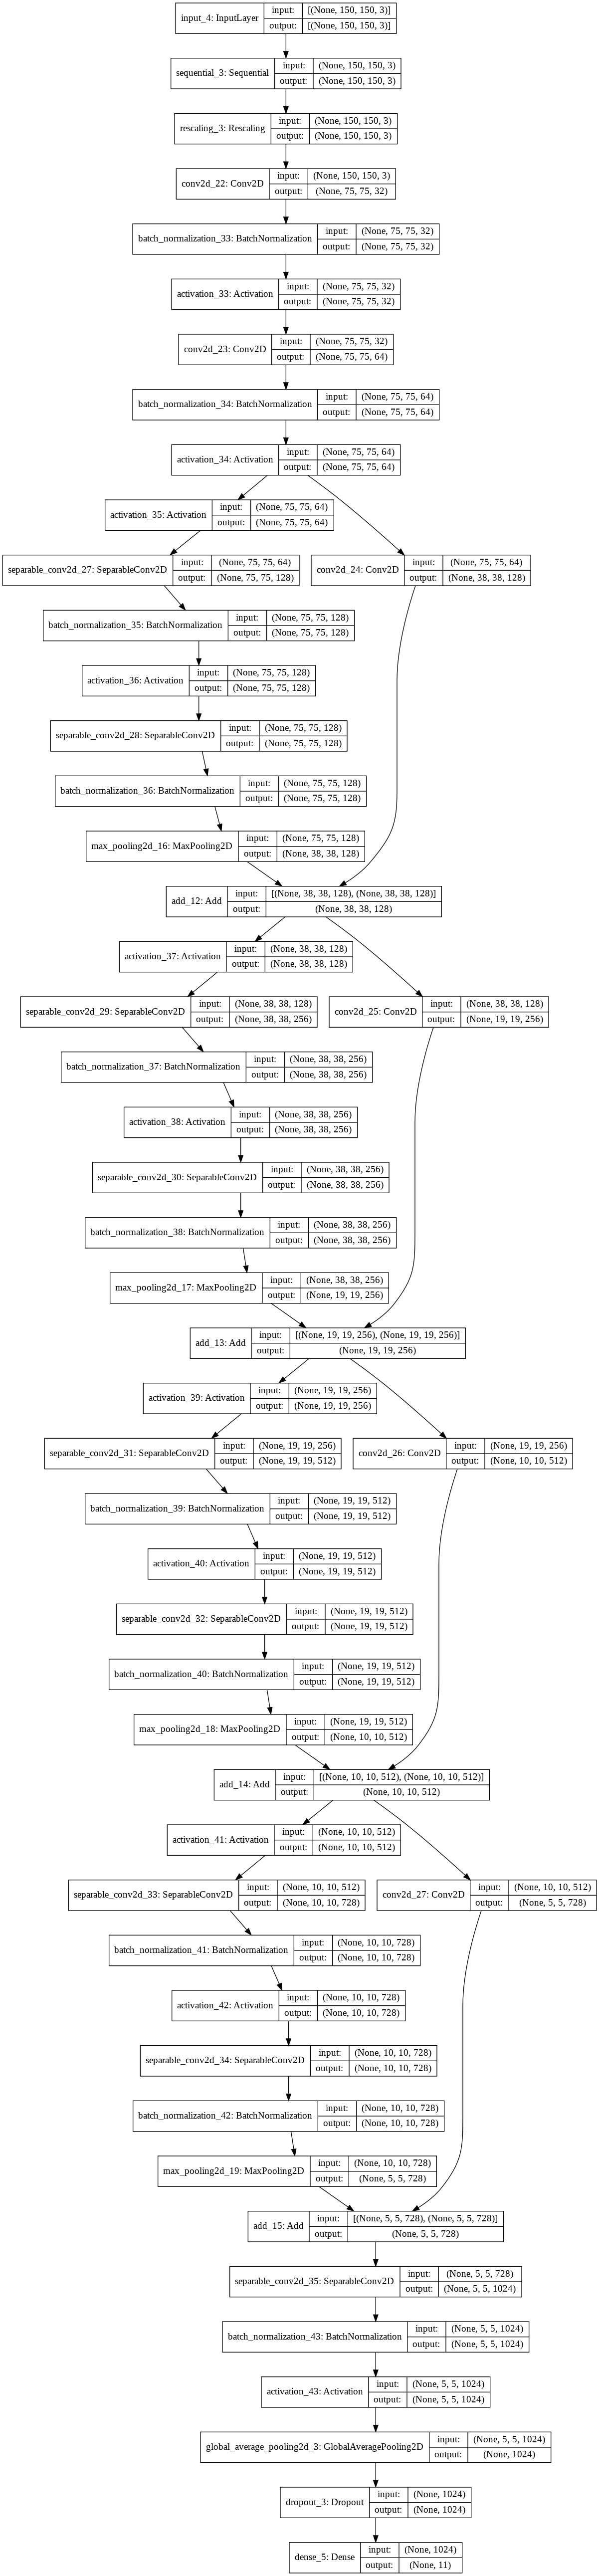

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=11)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/15
445/445 [==============================] - 342s 764ms/step - loss: 2.1745 - accuracy: 0.2766 - val_loss: 2.0197 - val_accuracy: 0.3326
Epoch 2/15
445/445 [==============================] - 341s 767ms/step - loss: 2.0921 - accuracy: 0.2851 - val_loss: 2.0264 - val_accuracy: 0.3371
Epoch 3/15
445/445 [==============================] - 342s 769ms/step - loss: 2.0457 - accuracy: 0.2945 - val_loss: 2.3323 - val_accuracy: 0.3191
Epoch 4/15
445/445 [==============================] - 342s 769ms/step - loss: 2.0240 - accuracy: 0.3094 - val_loss: 5.9306 - val_accuracy: 0.1393
Epoch 5/15
445/445 [==============================] - 342s 768ms/step - loss: 1.9608 - accuracy: 0.3465 - val_loss: 2.6665 - val_accuracy: 0.2629
Epoch 6/15
445/445 [==============================] - 341s 767ms/step - loss: 1.9405 - accuracy: 0.3406 - val_loss: 2.2315 - val_accuracy: 0.2674
Epoch 7/15
445/445 [==============================] - 341s 765ms/step - loss: 1.9041 - accuracy: 0.3431 - val_loss: 1.8615 -

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

#Training With TransfarLearning

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
def extract_features(TOVdata, sample_count):
  batch_size = 20
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  i = 0
  for inputs_batch, labels_batch in TOVdata:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      # Note that since generators yield data indefinitely in a loop,
      # we must `break` after every image has been seen once.
      break
  return features, labels

In [ ]:
train_features, train_labels = extract_features(train_ds, 2225)
validation_features, validation_labels = extract_features(val_ds, 445)

In [97]:
train_features = np.reshape(train_features, (2225, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (445, 4 * 4 * 512))

In [98]:
print(train_features.shape)

(2225, 8192)

In [99]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [100]:
history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
112/112 [==============================] - 3s 23ms/step - loss: 25.1053 - acc: 0.3103 - val_loss: 11.0130 - val_acc: 0.4225
Epoch 2/30
112/112 [==============================] - 2s 22ms/step - loss: 14.9924 - acc: 0.4557 - val_loss: 7.7353 - val_acc: 0.5146
Epoch 3/30
112/112 [==============================] - 3s 25ms/step - loss: 10.2617 - acc: 0.5588 - val_loss: 6.1922 - val_acc: 0.5955
Epoch 4/30
112/112 [==============================] - 3s 30ms/step - loss: 7.6309 - acc: 0.5929 - val_loss: 5.0086 - val_acc: 0.6315
Epoch 5/30
112/112 [==============================] - 4s 36ms/step - loss: 5.8074 - acc: 0.6628 - val_loss: 4.4483 - val_acc: 0.6629
Epoch 6/30
112/112 [==============================] - 3s 24ms/step - loss: 4.8634 - acc: 0.6862 - val_loss: 3.9092 - val_acc: 0.6921
Epoch 7/30
112/112 [==============================] - 2s 21ms/step - loss: 3.7007 - acc: 0.7439 - val_loss: 3.6445 - val_acc: 0.7101
Epoch 8/30
112/112 [==============================] - 2s 22ms/ste

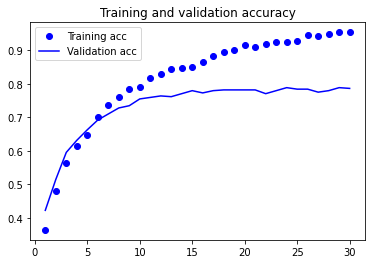

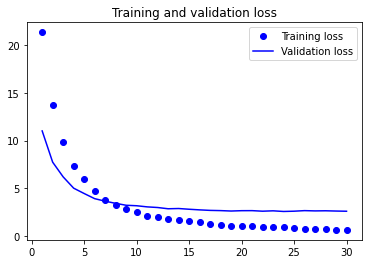

In [101]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [143]:
import numpy as np
img = keras.preprocessing.image.load_img(
    "/content/1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
#print(img_array.shape)
img_array = conv_base.predict(img_array)
#img_array.shape
img_array = tf.squeeze(img_array)
#train_features, train_labels = extract_features(img, 2225)
#predictions = model.predict(img_array[:])
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)


TensorShape([8192])

In [161]:
img_path = '/content/1.jpg'
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.
# Its shape is (1, 150, 150, 3)
img_array = conv_base.predict(img_tensor)
image_features = np.reshape(img_array, (1, 4 * 4 * 512))
predictions = model.predict(image_features)
category = predictions.argmax()
score = predictions.max()
print("the category is: {} \nwith probability value: {}".format(category, score/1*100))

the category is: 1 
with probability value: 36.567217111587524
